In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
import importlib
import ids_common
importlib.reload(ids_common)

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [3]:
df_orig = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)
df_orig.shape

(240446, 61)

In [4]:
df_orig['Attack_label'].value_counts()

Attack_label
1    120223
0    120223
Name: count, dtype: int64

<Axes: xlabel='Attack_label'>

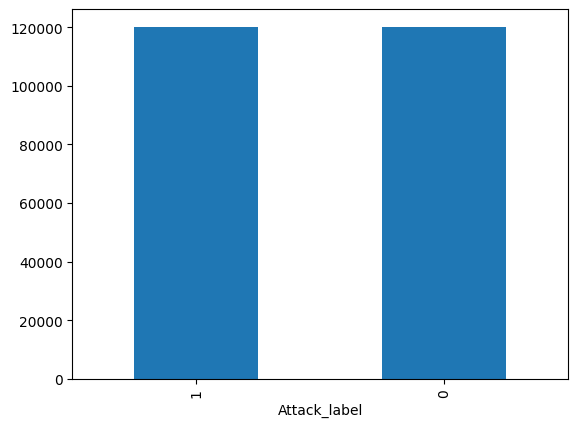

In [5]:
# Figure [traffic distribution]: Class distribution with respect to 'Attack_label'
df_orig['Attack_label'].value_counts().plot.bar()

<Axes: xlabel='Attack_type'>

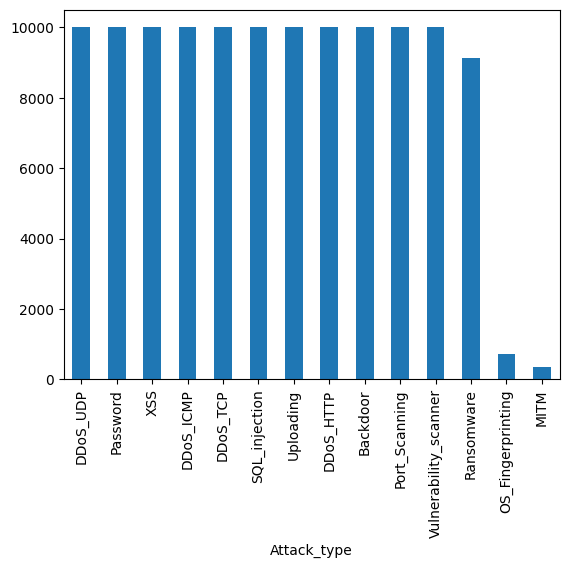

In [6]:
# Figure [attack distribution]: Class distribution with respect to 'Attack_type'
df_orig[df_orig['Attack_label']==1]['Attack_type'].value_counts().plot.bar()

In [11]:
df = df_orig

df_train, df_test = ids_common.ds_split(df, seed=42)

dataset = {}
dataset['2_class'] = {
    'train': ids_common.make_2_class(df_train),
    'test': ids_common.make_2_class(df_test)
}

dataset['14_class'] = {
    'train':ids_common.make_14_class(df_train),
    'test':ids_common.make_14_class(df_test)
}

dataset['15_class'] = {
    'train':ids_common.make_15_class(df_train),
    'test':ids_common.make_15_class(df_test)
}


def get_data(class_type, set_type):
    X, y = dataset[class_type][set_type]
    return X, y


def make_classifier(name, cls):
    X_train, y_train = get_data(name, 'train')
    X_test, y_test = get_data(name, 'test')

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    cls.fit(X_train, y_train)

    y_train_predict = cls.predict(X_train)
    y_test_predict = cls.predict(X_test)

    print(f'{cls.__class__.__name__}:')
    print(f'Train score: {cls.score(X_train, y_train)}')
    print(f'Test score:  {cls.score(X_test, y_test)}')

    ids_common.report(y_train, y_train_predict, y_test, y_test_predict, le)
    ids_common.plot_cm(y_test, y_test_predict, name=cls.__class__.__name__, le=le)
     
    return cls, le

DecisionTreeClassifier:
Train score: 0.9661668988750026
Test score:  0.9648367644000831
TRAIN:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     96178
           1       1.00      0.93      0.96     96178

    accuracy                           0.97    192356
   macro avg       0.97      0.97      0.97    192356
weighted avg       0.97      0.97      0.97    192356

TEST:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



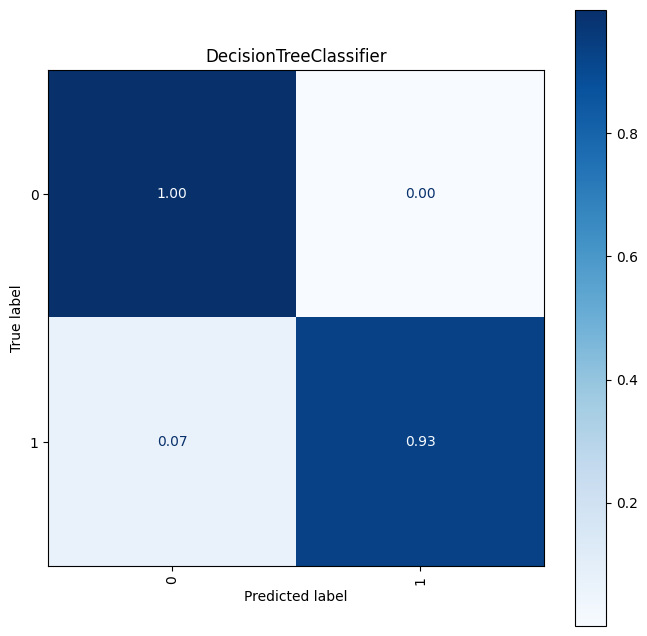

LogisticRegression:
Train score: 0.5845723554243174
Test score:  0.5851112497400707
TRAIN:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     96178
           1       0.61      0.46      0.53     96178

    accuracy                           0.58    192356
   macro avg       0.59      0.58      0.58    192356
weighted avg       0.59      0.58      0.58    192356

TEST:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     24045
           1       0.61      0.46      0.53     24045

    accuracy                           0.59     48090
   macro avg       0.59      0.59      0.58     48090
weighted avg       0.59      0.59      0.58     48090



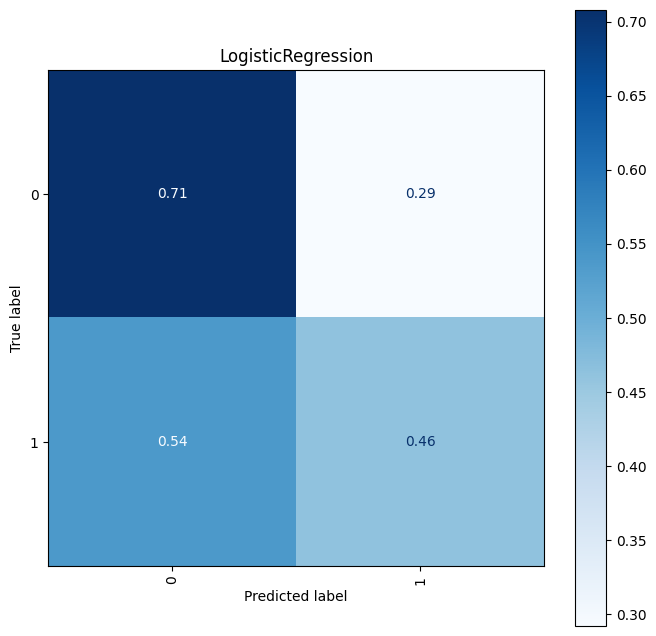

In [12]:

class_2_dt, le_2 = make_classifier( 
        '2_class',
        DecisionTreeClassifier(
                **{'criterion': 'entropy', 'max_depth': 8}, random_state=SEED),
)

class_2_lr, le_2 = make_classifier( 
        '2_class',
        LogisticRegression(
        **{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}, max_iter=10000, random_state=SEED)
)

DecisionTreeClassifier: [0.965, 0.967, 0.965, 0.965]
LogisticRegression: [0.585, 0.591, 0.585, 0.579]


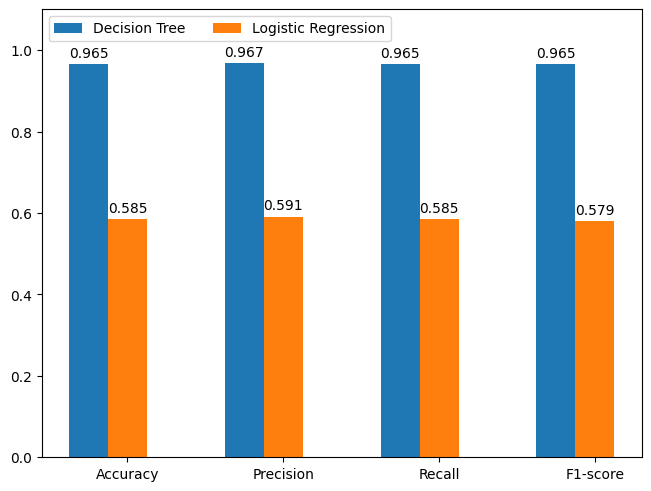

In [20]:
# Figure [detection dt lr]: Detection performance results.

X_test, y_test = get_data('2_class', 'test')
class_2_dt_report = classification_report(y_test, class_2_dt.predict(X_test), output_dict=True)
class_2_dt_report

dt = [class_2_dt_report['accuracy'], 
      class_2_dt_report['macro avg']['precision'], 
      class_2_dt_report['macro avg']['recall'], 
      class_2_dt_report['macro avg']['f1-score']
      ]

class_2_lr_report = classification_report(y_test, class_2_lr.predict(X_test), output_dict=True)

lr = [class_2_lr_report['accuracy'], 
      class_2_lr_report['macro avg']['precision'], 
      class_2_lr_report['macro avg']['recall'], 
      class_2_lr_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_2_lr.__class__.__name__}: {lr}')

reports = {
    'Decision Tree': dt,
    'Logistic Regression': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

RandomForestClassifier:
Train score: 0.9978685354239015
Test score:  0.9181534622582658
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      1.00      1.00      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      0.97      0.98       579
             Password       1.00      1.00      1.00      8000
        Port_Scanning       0.98      1.00      0.99      8000
           Ransomware       1.00      1.00      1.00      7313
        SQL_injection       1.00      1.00      1.00      8000
            Uploading       1.00      0.99      0.99      8000
Vulnerability_scanner       1.00      1.00      1.00      8000
                  XSS 

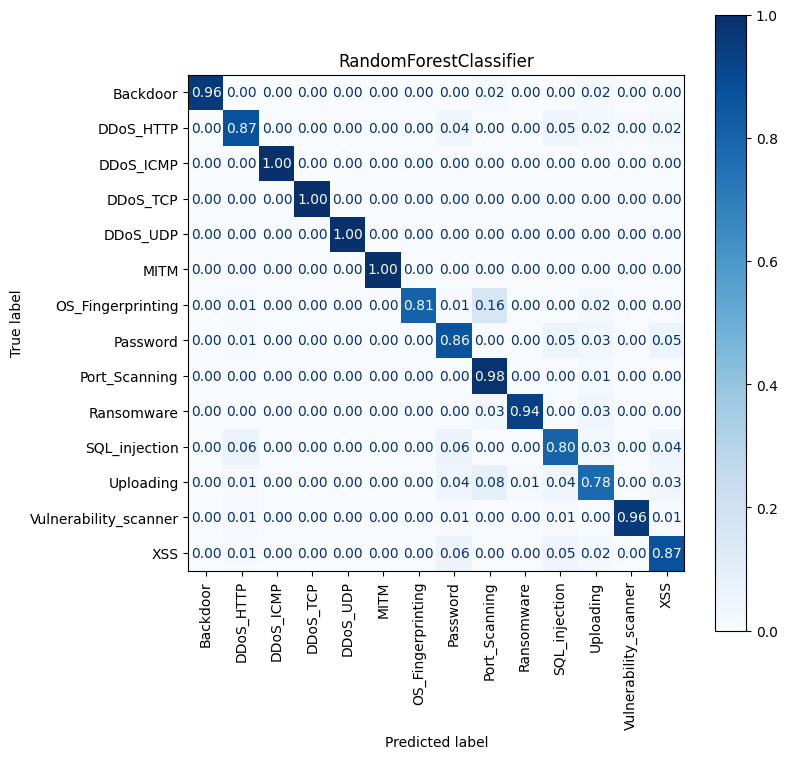

In [29]:
class_14_rf, le_14 = make_classifier( 
        '14_class',
        RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)
)

XGBClassifier:
Train score: 0.9500197550375346
Test score:  0.9229361613641089
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.95      0.94      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      0.82      0.90       579
             Password       0.85      0.95      0.90      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.88      0.91      0.90      8000
            Uploading       0.94      0.81      0.87      8000
Vulnerability_scanner       1.00      0.97      0.99      8000
                  XSS       0.9

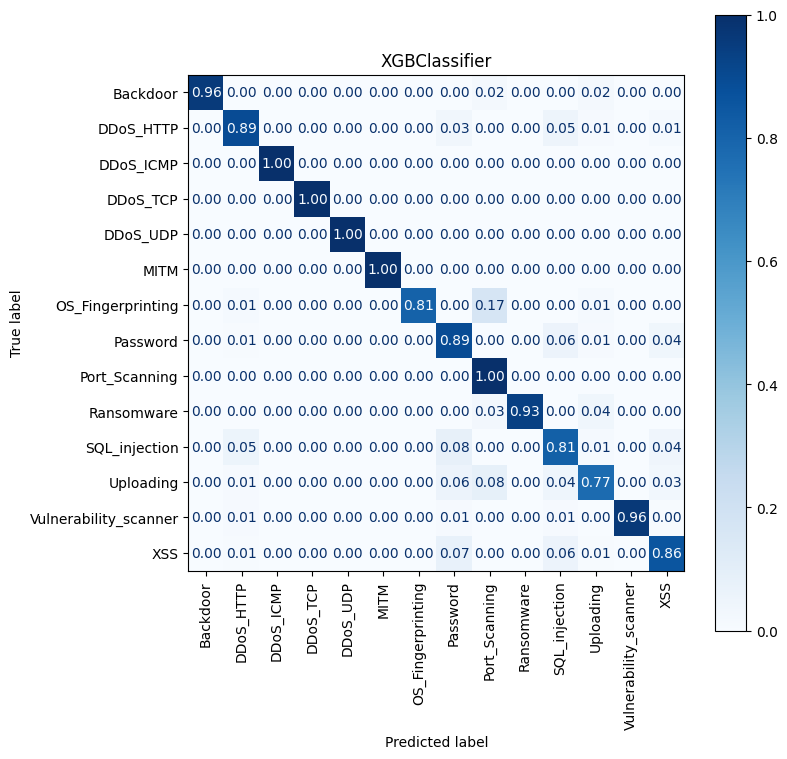

In [23]:
class_14_xgb, le_14 = make_classifier( 
        '14_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

DecisionTreeClassifier: [0.918, 0.929, 0.917, 0.922]
XGBClassifier: [0.923, 0.936, 0.921, 0.927]


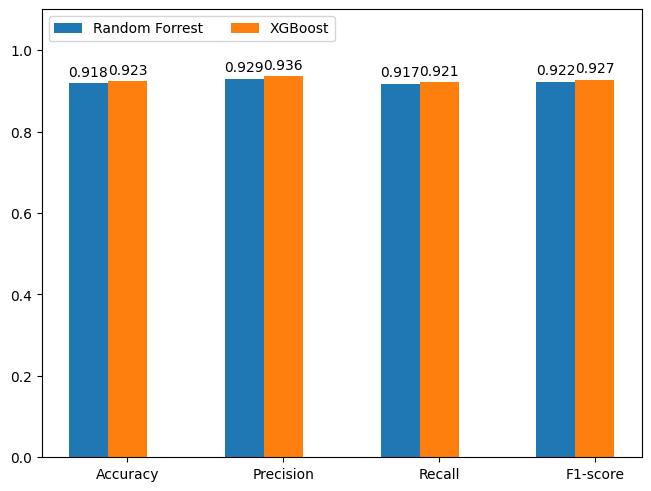

In [30]:
# Figure  [classification rf xgb 14 class] : Classification performance results.

X_test, y_test = get_data('14_class', 'test')
class_14_rf_report = classification_report(y_test, le_14.inverse_transform(class_14_rf.predict(X_test)), output_dict=True)

dt = [class_14_rf_report['accuracy'], 
      class_14_rf_report['macro avg']['precision'], 
      class_14_rf_report['macro avg']['recall'], 
      class_14_rf_report['macro avg']['f1-score']
      ]

class_14_xgb_report = classification_report(y_test, le_14.inverse_transform(class_14_xgb.predict(X_test)), output_dict=True)

lr = [class_14_xgb_report['accuracy'], 
      class_14_xgb_report['macro avg']['precision'], 
      class_14_xgb_report['macro avg']['recall'], 
      class_14_xgb_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_14_xgb.__class__.__name__}: {lr}')

reports = {
    'Random Forrest': dt,
    'XGBoost': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

RandomForestClassifier:
Train score: 0.9826779512986338
Test score:  0.9487835308796008
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      0.98      0.99      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       0.97      1.00      0.98     96178
    OS_Fingerprinting       1.00      0.96      0.98       579
             Password       1.00      0.90      0.95      8000
        Port_Scanning       0.97      1.00      0.98      8000
           Ransomware       1.00      0.99      1.00      7313
        SQL_injection       1.00      0.90      0.95      8000
            Uploading       1.00      0.91      0.95      8000
Vulnerability_scanner 

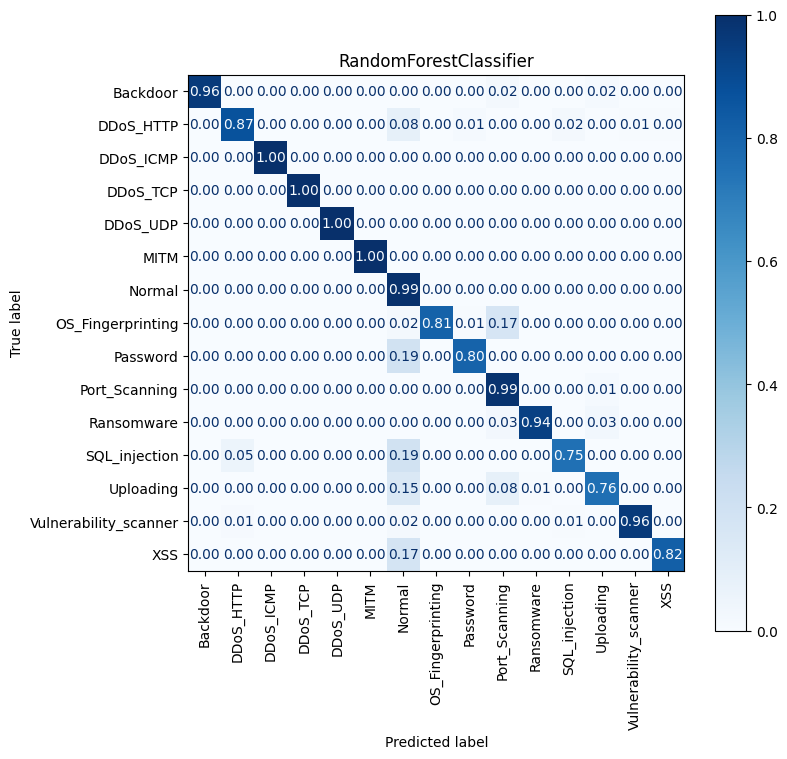

XGBClassifier:
Train score: 0.9566948782465845
Test score:  0.9526096901642753
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.97      0.92      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       0.94      1.00      0.97     96178
    OS_Fingerprinting       1.00      0.83      0.91       579
             Password       1.00      0.80      0.89      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.98      0.78      0.87      8000
            Uploading       0.95      0.77      0.85      8000
Vulnerability_scanner       1.0

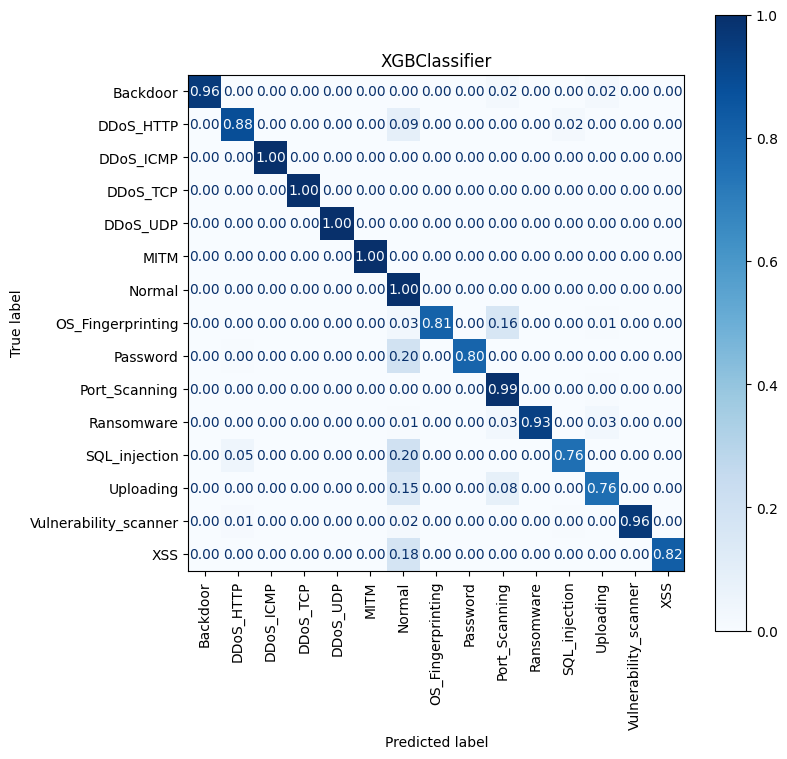

In [33]:
class_15_rf, le_15 = make_classifier( 
        '15_class',
        RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)
)

class_15_xgb, le_15 = make_classifier( 
        '15_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

DecisionTreeClassifier: [0.949, 0.964, 0.909, 0.934]
XGBClassifier: [0.953, 0.974, 0.912, 0.939]


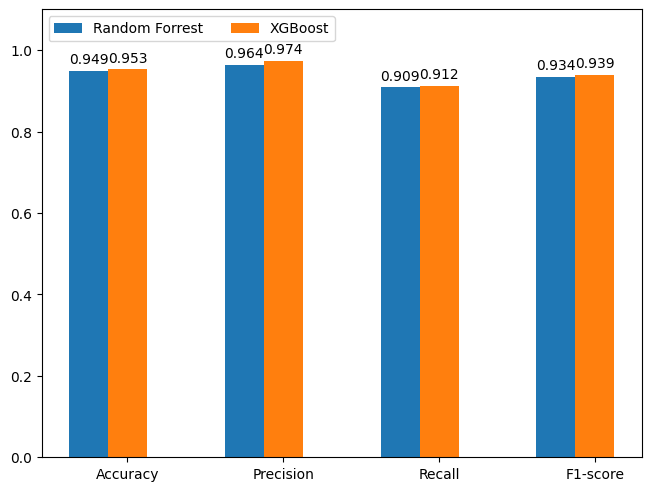

In [34]:
# Figure [classification rf xgb]: Classification performance results.

X_test, y_test = get_data('15_class', 'test')
class_15_rf_report = classification_report(y_test, le_15.inverse_transform(class_15_rf.predict(X_test)), output_dict=True)

dt = [class_15_rf_report['accuracy'], 
      class_15_rf_report['macro avg']['precision'], 
      class_15_rf_report['macro avg']['recall'], 
      class_15_rf_report['macro avg']['f1-score']
      ]

class_15_xgb_report = classification_report(y_test, le_15.inverse_transform(class_15_xgb.predict(X_test)), output_dict=True)

lr = [class_15_xgb_report['accuracy'], 
      class_15_xgb_report['macro avg']['precision'], 
      class_15_xgb_report['macro avg']['recall'], 
      class_15_xgb_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_14_xgb.__class__.__name__}: {lr}')

reports = {
    'Random Forrest': dt,
    'XGBoost': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()